#####

## Fantasy Football Forecast 2025
#### In this notebook I use the machine learning algorithm XGBoost to create models which can be used to predict a player's 2025 fantasy finishes. It must be noted that these models are not perfect and should not be taken as fact. With all of the noise which affects football stats every year (injuries, weather conditions, coaching, etc...) there is only so much variance that can be explained by the models.

##### Importing Packages and Data

In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
QBs = pd.read_csv('../Fantasyfb_Data/QBs.csv')
RBs =pd.read_csv('../Fantasyfb_Data/RBs.csv')
WRs = pd.read_csv('../Fantasyfb_Data/WRs.csv')
TEs = pd.read_csv('../Fantasyfb_Data/TEs.csv')

##### A new column was created somewhere in the exporting/importing the data which I remove here.

In [3]:
QBs.drop(columns=['Unnamed: 0', 'Tgt_gm'], inplace=True)
RBs.drop(columns=['Unnamed: 0', 'Tgt_Binned', 'Att_Rush_Binned', 'PPR_PassAtt'], inplace=True)
WRs.drop(columns=['Unnamed: 0', 'PPR_PassAtt'], inplace=True)
TEs.drop(columns=['Unnamed: 0', 'PPR_PassAtt'], inplace=True)

## QBs Model
#### For each model I create a few extra features. These include career averages, lagged stats for the previous two seasons, and the 'PPR_next_year' column, which will be what the model is predicting.

##### Note: I also select the training/testing data at the end of the second cell. The model is trained on 2017-2022 with 2023 being used for validation. The 2024 data is used to make 2025 predictions.

In [4]:
QBs = QBs.sort_values(['Player', 'Year'])

In [5]:
# Career Stats

QBs['Career_Pass_Att'] = QBs.groupby('Player')['Att_Pass'].cumsum().shift(1)
QBs['Career_Pass_Att'] = QBs['Career_Pass_Att'].fillna(0)

QBs['Career_Avg_PPR'] = QBs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
QBs['Career_Avg_PPR'] = QBs['Career_Avg_PPR'].fillna(0)

QBs['Career_Avg_PassRating'] = QBs.groupby('Player')['Passer_Rating'].expanding().mean().shift(1).reset_index(level=0, drop=True)
QBs['Career_Avg_PassRating'] = QBs['Career_Avg_PassRating'].fillna(0)

#Lagged Stats
QBs['Cmp_last_year'] = QBs.groupby('Player')['Cmp'].shift(1)
QBs['Cmp_2_years'] = QBs.groupby('Player')['Cmp'].shift(2)

QBs['Att_Pass_last_year'] = QBs.groupby('Player')['Att_Pass'].shift(1)
QBs['Att_Pass_2_years'] = QBs.groupby('Player')['Att_Pass'].shift(2)

QBs['Yds_Pass_last_year'] = QBs.groupby('Player')['Yds_Pass'].shift(1)
QBs['Yds_Pass_2_years'] = QBs.groupby('Player')['Yds_Pass'].shift(2)

QBs['Att_Rush_last_year'] = QBs.groupby('Player')['Att_Rush'].shift(1)
QBs['Att_Rush_2_years'] = QBs.groupby('Player')['Att_Rush'].shift(2)

QBs['Yds_Rush_last_year'] = QBs.groupby('Player')['Yds (Rush)'].shift(1)
QBs['Yds_Rush_2_years'] = QBs.groupby('Player')['Yds (Rush)'].shift(2)

QBs['TD_last_year'] = QBs.groupby('Player')['TD'].shift(1)
QBs['TD_2_years'] = QBs.groupby('Player')['TD'].shift(2)

QBs['Snaps_last_year'] = QBs.groupby('Player')['Total_Snaps'].shift(1)
QBs['Snaps_2_years'] = QBs.groupby('Player')['Total_Snaps'].shift(2)

QBs['PassRating_last_year'] = QBs.groupby('Player')['Passer_Rating'].shift(1)
QBs['PassRating_2_years'] = QBs.groupby('Player')['Passer_Rating'].shift(2)

#Lagged Fantasy Points for Testing
QBs['PPR_next_year'] = QBs.groupby('Player')['PPR'].shift(-1)
QBs_train = QBs[QBs['Year'] < 2023].dropna(subset=['PPR_next_year'])
QBs_val = QBs[QBs['Year'] == 2023].dropna(subset=['PPR_next_year'])
QBs_test = QBs[QBs['Year'] == 2024]

#### Setting features and defining training/testing data:
##### In the process of creating the quarterbacks model I used the first following cell to turn certain features on and off, then seeing the effects on the model. I settled on using every feature besides snap counts for quarterbacks. Since starting quarterbacks are predetermined to take the majority of their teams snaps, the tradeoff between their colinearity with other volume based stats and their value becomes one sided. I deem snap counts to be more valuable for other positions as we'll see with RBs, WRs, and TEs.

In [6]:
QBs_Features = ['Age', 'Cmp', 'Att_Pass', 'Yds_Pass', 'Att_Rush', 'Yds (Rush)', 'TD', 
                #'Snaps_last_year', 'Snaps_2_years', 'Total_Snaps',
                'Passer_Rating','Career_Pass_Att', 'Career_Avg_PPR',
                'Career_Avg_PassRating', 'Cmp_last_year', 'Cmp_2_years', 'Att_Pass_last_year', 'Att_Pass_2_years',
                'Yds_Pass_last_year', 'Yds_Pass_2_years', 'Att_Rush_last_year', 'Att_Rush_2_years', 'Yds_Rush_last_year',
                'Yds_Rush_2_years', 'TD_last_year', 'TD_2_years',
                'PassRating_last_year', 'PassRating_2_years']

X_train, y_train = QBs_train[QBs_Features], QBs_train['PPR_next_year']
X_val,   y_val   = QBs_val[QBs_Features],   QBs_val['PPR_next_year']
X_test           = QBs_test[QBs_Features]


##### Training and finding optimal hyperparameters

In [7]:
model = xgb.XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.05,
    max_depth = 3,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 10,
    reg_alpha = 0,
    random_state =3
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


##### For each model I used the 2023 data for validation, since we already know the fantasy finishes for 2024. By adjusting hyperparamters in the above cell, we can find the optimal values of root mean squared error and R squared for both the training and validation data, helping to minimize the bias-variance tradeoff.

In [8]:
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R^2:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R^2:", val_r2)



Training RMSE: 58.627461527145186
Training R^2: 0.7769866950456008
Validation RMSE: 79.9046060312041
Validation R^2: 0.5522229090638986


##### Actual vs Predicted 2023 Visualization

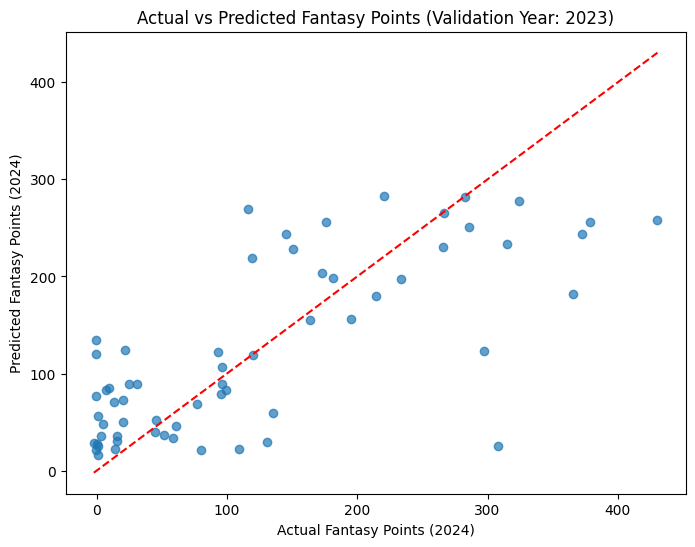

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()


#### Feature importances
##### By using .feature_importances_ in the XGBoost package we can see which features contributed the most to the model. For quarterbacks these are the previous season's passing yards, completions, and pass attempts.

In [ ]:
importance = model.feature_importances_
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(15))

                  Feature  Importance
3                Yds_Pass    0.273659
1                     Cmp    0.107511
2                Att_Pass    0.063374
7           Passer_Rating    0.045446
4                Att_Rush    0.042146
17     Att_Rush_last_year    0.037724
15     Yds_Pass_last_year    0.036777
5              Yds (Rush)    0.034124
0                     Age    0.032286
11          Cmp_last_year    0.029362
24     PassRating_2_years    0.028229
13     Att_Pass_last_year    0.028033
10  Career_Avg_PassRating    0.026738
14       Att_Pass_2_years    0.025645
23   PassRating_last_year    0.024671


#### 2025 Predictions QBs
##### Using .predict() on the 2024 data, the model can predict fantasy points for the upcoming season. (Results listed at the end of this notebook)

In [9]:
future_preds = model.predict(X_test)
QBs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_39868/4164295603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QBs_test['2025_Fantasy_Projection'] = future_preds


## RBs model

#### Creating Features
##### This time we create career averages for rushing stats as well as lagged stats for rushing/receiving

In [10]:
RBs = RBs.sort_values(['Player', 'Year'])

In [11]:
# Career Stats

RBs['Career_Att_Rush'] = RBs.groupby('Player')['Att_Rush'].cumsum().shift(1)
RBs['Career_Att_Rush'] = RBs['Career_Att_Rush'].fillna(0)

RBs['Career_Avg_PPR'] = RBs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
RBs['Career_Avg_PPR'] = RBs['Career_Avg_PPR'].fillna(0)

RBs['Career_Avg_Y/A'] = RBs.groupby('Player')['Y/A'].expanding().mean().shift(1).reset_index(level=0, drop=True)
RBs['Career_Avg_Y/A'] = RBs['Career_Avg_Y/A'].fillna(0)

#Lagged Stats
RBs['Att_Rush_last_year'] = RBs.groupby('Player')['Att_Rush'].shift(1)
RBs['Att_Rush_2_years'] = RBs.groupby('Player')['Att_Rush'].shift(2)

RBs['Yds_Rush_last_year'] = RBs.groupby('Player')['Yds (Rush)'].shift(1)
RBs['Yds_Rush_2_years'] = RBs.groupby('Player')['Yds (Rush)'].shift(2)

RBs['TD_last_year'] = RBs.groupby('Player')['TD'].shift(1)
RBs['TD_2_years'] = RBs.groupby('Player')['TD'].shift(2)

RBs['Snaps_last_year'] = RBs.groupby('Player')['Total_Snaps'].shift(1)
RBs['Snaps_2_years'] = RBs.groupby('Player')['Total_Snaps'].shift(2)

RBs['Tgt_last_year'] = RBs.groupby('Player')['Tgt'].shift(1)
RBs['Tgt_2_years'] = RBs.groupby('Player')['Tgt'].shift(2)

RBs['Rec_last_year'] = RBs.groupby('Player')['Rec'].shift(1)
RBs['Rec_2_years'] = RBs.groupby('Player')['Rec'].shift(2)

RBs['Yds_rec_last_year'] = RBs.groupby('Player')['Yds_Rec'].shift(1)
RBs['Yds_rec_2_years'] = RBs.groupby('Player')['Yds_Rec'].shift(2)

#Lagged Fantasy Points for Testing
RBs['PPR_next_year'] = RBs.groupby('Player')['PPR'].shift(-1)
RBs_train = RBs[RBs['Year'] < 2023].dropna(subset=['PPR_next_year'])
RBs_val = RBs[RBs['Year'] == 2023].dropna(subset=['PPR_next_year'])
RBs_test = RBs[RBs['Year'] == 2024]

#### Setting features and defining training/testing data
##### Since there was no feature that stood out in the feature importances as possibly skewing the model, I left all features turned on here.

In [12]:
RBs_Features = ['Age', 'Att_Rush', 'Y/A', 'Yds (Rush)','Tgt', 'Rec', 'Yds_Rec',
                'TD','TD_last_year','TD_2_years',
                'Total_Snaps','Career_Att_Rush',
       'Career_Avg_PPR', 'Career_Avg_Y/A', 'Att_Rush_last_year',
       'Yds_Rush_last_year', 'Snaps_last_year',
       'Tgt_last_year', 'Rec_last_year',  'Yds_rec_last_year',
       'Att_Rush_2_years', 'Yds_Rush_2_years','Snaps_2_years',
       'Tgt_2_years', 'Rec_2_years', 'Yds_rec_2_years'
       ]

X_train, y_train = RBs_train[RBs_Features], RBs_train['PPR_next_year']
X_val, y_val = RBs_val[RBs_Features], RBs_val['PPR_next_year']
X_test       = RBs_test[RBs_Features]

##### Training and finding optimal hyperparameters

In [13]:
model = xgb.XGBRegressor(
    n_estimators = 350,
    learning_rate = 0.05,
    max_depth = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 10,
    reg_alpha = 1,
    random_state =3
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


##### Validation using 2023 data

In [14]:
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R^2:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R^2:", val_r2)

Training RMSE: 49.13464786785576
Training R^2: 0.6960168021209725
Validation RMSE: 68.45371868525362
Validation R^2: 0.5051646039789286


##### Actual vs Predicted Visualization RBs 2023

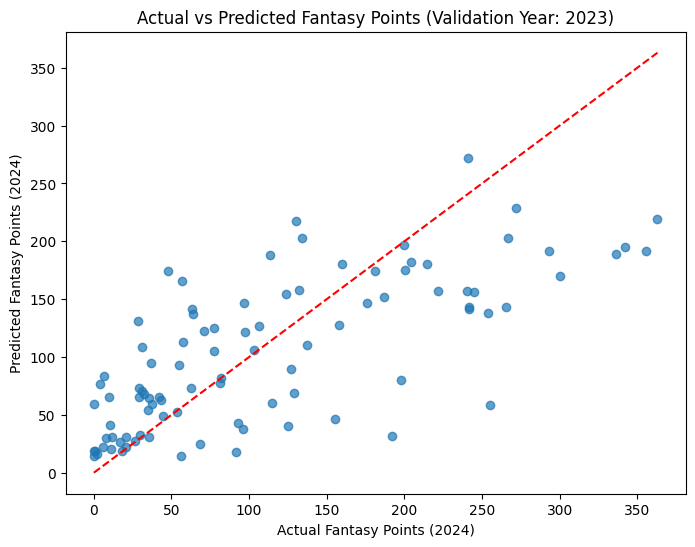

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()


#### Feature importances:
##### The most predictive features for RBs were rushing yards the season before that which we're predicting as well as touchdowns, receiving yards, and total snaps. Touchdowns surprised me – they're volatile from season to season (perhaps less so for running backs) – but not enough to remove from the features. 

In [15]:
importance = model.feature_importances_
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(15))  # Top 15 features

             Feature  Importance
3         Yds (Rush)    0.204586
7                 TD    0.095579
6            Yds_Rec    0.081882
10       Total_Snaps    0.071053
24       Rec_2_years    0.052907
5                Rec    0.047431
0                Age    0.041072
2                Y/A    0.031055
21  Yds_Rush_2_years    0.026484
23       Tgt_2_years    0.025527
1           Att_Rush    0.025423
4                Tgt    0.025003
22     Snaps_2_years    0.024293
8       TD_last_year    0.023163
16   Snaps_last_year    0.022533


#### 2025 Predictions RBs

In [16]:
future_preds = model.predict(X_test)
RBs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_39868/3481768187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RBs_test['2025_Fantasy_Projection'] = future_preds


## WRs Model

#### Creating Features
##### The features for the receiving model are more or less the same as for running backs. The main difference is that for the career average type stats I chose to use targets and average yards per reception since those would capture experience and efficiency for receivers.

In [17]:
WRs = WRs.sort_values(['Player', 'Year'])

In [18]:
# Career Stats

WRs['Career_Tgt'] = WRs.groupby('Player')['Tgt'].cumsum().shift(1)
WRs['Career_Tgt'] = WRs['Career_Tgt'].fillna(0)

WRs['Career_Avg_PPR'] = WRs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
WRs['Career_Avg_PPR'] = WRs['Career_Avg_PPR'].fillna(0)

WRs['Career_Avg_Yds_per_rec'] = WRs.groupby('Player')['Yds_per_rec'].expanding().mean().shift(1).reset_index(level=0, drop=True)
WRs['Career_Avg_Yds_per_rec'] = WRs['Career_Avg_Yds_per_rec'].fillna(0)

#Lagged Stats
WRs['Att_Rush_last_year'] = WRs.groupby('Player')['Att_Rush'].shift(1)
WRs['Att_Rush_2_years'] = WRs.groupby('Player')['Att_Rush'].shift(2)

WRs['Yds_Rush_last_year'] = WRs.groupby('Player')['Yds (Rush)'].shift(1)
WRs['Yds_Rush_2_years'] = WRs.groupby('Player')['Yds (Rush)'].shift(2)

WRs['TD_last_year'] = WRs.groupby('Player')['TD'].shift(1)
WRs['TD_2_years'] = WRs.groupby('Player')['TD'].shift(2)

WRs['Snaps_last_year'] = WRs.groupby('Player')['Total_Snaps'].shift(1)
WRs['Snaps_2_years'] = WRs.groupby('Player')['Total_Snaps'].shift(2)

WRs['Tgt_last_year'] = WRs.groupby('Player')['Tgt'].shift(1)
WRs['Tgt_2_years'] = WRs.groupby('Player')['Tgt'].shift(2)

WRs['Rec_last_year'] = WRs.groupby('Player')['Rec'].shift(1)
WRs['Rec_2_years'] = WRs.groupby('Player')['Rec'].shift(2)

WRs['Yds_rec_last_year'] = WRs.groupby('Player')['Yds_Rec'].shift(1)
WRs['Yds_rec_2_years'] = WRs.groupby('Player')['Yds_Rec'].shift(2)

#Lagged Fantasy Points for Testing
WRs['PPR_next_year'] = WRs.groupby('Player')['PPR'].shift(-1)
WRs_train = WRs[WRs['Year'] < 2023].dropna(subset=['PPR_next_year'])
WRs_val = WRs[WRs['Year'] == 2023].dropna(subset=['PPR_next_year'])
WRs_test = WRs[WRs['Year'] == 2024]

#### Setting features and defining training/test data:
##### Once again, no features stood out as being unlikely to be particularly predictive when examining feature importances, so all features remain turned on.

In [19]:
WRs_Features = ['Age', 'Tgt', 'Rec', 'Yds_Rec', 'Yds_per_rec',
                'TD', 'TD_last_year',
                'TD_2_years',
                'Total_Snaps', 'TM SNAP %','Career_Tgt', 'Career_Avg_PPR', 'Career_Avg_Yds_per_rec',
                'Snaps_last_year', 'Tgt_last_year', 'Rec_last_year','Yds_rec_last_year',
                'Yds_rec_2_years','Rec_2_years','Tgt_2_years','Snaps_2_years',
                ]

X_train, y_train = WRs_train[WRs_Features], WRs_train['PPR_next_year']
X_val, y_val = WRs_val[WRs_Features], WRs_val['PPR_next_year']
X_test       = WRs_test[WRs_Features]

##### Training the model and selecting hyperparameters

In [20]:
model = xgb.XGBRegressor(
    n_estimators = 170,
    learning_rate = 0.05,
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 30,
    reg_alpha = 0,
    random_state =6
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


##### Validating on 2023 data

In [ ]:
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R^2:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R^2:", val_r2)

Training RMSE: 40.901639873251284
Training R²: 0.7751493418850343
Validation RMSE: 58.351199822669344
Validation R²: 0.5287874095405873


##### Actual vs Predicted Visualization WRs 2023

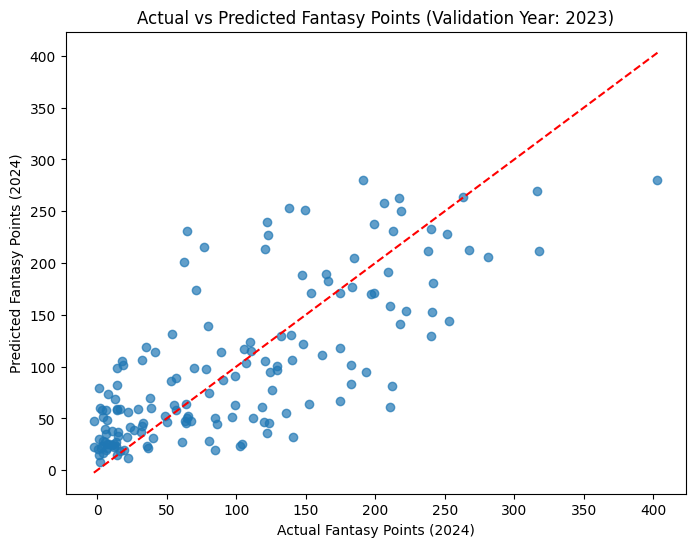

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()

#### Feature Importances:
##### Like the model for running backs, yards contributed most to the model, this time being yards receiving. Receptions was the second largest contributer followed by targets and touchdowns.

In [ ]:
importance = model.feature_importances_
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(15))  # Top 15 features

              Feature  Importance
3             Yds_Rec    0.322328
2                 Rec    0.204282
1                 Tgt    0.064668
5                  TD    0.051637
16  Yds_rec_last_year    0.040679
15      Rec_last_year    0.032899
17    Yds_rec_2_years    0.026848
18        Rec_2_years    0.026816
11     Career_Avg_PPR    0.021866
9           TM SNAP %    0.019997
14      Tgt_last_year    0.019802
0                 Age    0.019498
6        TD_last_year    0.019250
10         Career_Tgt    0.017269
8         Total_Snaps    0.017219


#### 2025 Predictions WRs

In [ ]:
future_preds = model.predict(X_test)
WRs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_39868/1016118979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WRs_test['2025_Fantasy_Projection'] = future_preds


## TEs Model

#### Creating Features (Same stats selected as for WRs since the value of TEs also comes from pass catching)

In [22]:
TEs = TEs.sort_values(['Player', 'Year'])

In [23]:
# Career Stats

TEs['Career_Tgt'] = TEs.groupby('Player')['Tgt'].cumsum().shift(1)
TEs['Career_Tgt'] = TEs['Career_Tgt'].fillna(0)

TEs['Career_Avg_PPR'] = TEs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
TEs['Career_Avg_PPR'] = TEs['Career_Avg_PPR'].fillna(0)

TEs['Career_Avg_Yds_per_rec'] = TEs.groupby('Player')['Yds_per_rec'].expanding().mean().shift(1).reset_index(level=0, drop=True)
TEs['Career_Avg_Yds_per_rec'] = TEs['Career_Avg_Yds_per_rec'].fillna(0)

#Lagged Stats
TEs['Att_Rush_last_year'] = TEs.groupby('Player')['Att_Rush'].shift(1)
TEs['Att_Rush_2_years'] = TEs.groupby('Player')['Att_Rush'].shift(2)

TEs['Yds_Rush_last_year'] = TEs.groupby('Player')['Yds (Rush)'].shift(1)
TEs['Yds_Rush_2_years'] = TEs.groupby('Player')['Yds (Rush)'].shift(2)

TEs['TD_last_year'] = TEs.groupby('Player')['TD'].shift(1)
TEs['TD_2_years'] = TEs.groupby('Player')['TD'].shift(2)

TEs['Snaps_last_year'] = TEs.groupby('Player')['Total_Snaps'].shift(1)
TEs['Snaps_2_years'] = TEs.groupby('Player')['Total_Snaps'].shift(2)

TEs['Tgt_last_year'] = TEs.groupby('Player')['Tgt'].shift(1)
TEs['Tgt_2_years'] = TEs.groupby('Player')['Tgt'].shift(2)

TEs['Rec_last_year'] = TEs.groupby('Player')['Rec'].shift(1)
TEs['Rec_2_years'] = TEs.groupby('Player')['Rec'].shift(2)

TEs['Yds_rec_last_year'] = TEs.groupby('Player')['Yds_Rec'].shift(1)
TEs['Yds_rec_2_years'] = TEs.groupby('Player')['Yds_Rec'].shift(2)

#Lagged Fantasy Points for Testing
TEs['PPR_next_year'] = TEs.groupby('Player')['PPR'].shift(-1)
TEs_train = TEs[TEs['Year'] < 2023].dropna(subset=['PPR_next_year'])
TEs_val = TEs[TEs['Year'] == 2023].dropna(subset=['PPR_next_year'])
TEs_test = TEs[TEs['Year'] == 2024]

#### Feature selection
##### The only feature turned off here is TD_2_years, which is the touchdowns scored two seasons before the year in which data is being used to predict the following season. In other words, three seasons before the predicitons. It somehow had a large effect on the predictions even though touchdowns are very volatile. Since this is also a lagged stat by two years, I decided to turn it off.

In [24]:
TEs_Features = ['Age', 'Tgt', 'Rec', 'Yds_Rec', 'Yds_per_rec',
                'TD', 'TD_last_year',
                # 'TD_2_years',
                'Total_Snaps', 'TM SNAP %','Career_Tgt', 'Career_Avg_PPR', 'Career_Avg_Yds_per_rec',
                'Snaps_last_year', 'Tgt_last_year', 'Rec_last_year','Yds_rec_last_year',
                'Yds_rec_2_years','Rec_2_years','Tgt_2_years','Snaps_2_years',
                ]

X_train, y_train = TEs_train[TEs_Features], TEs_train['PPR_next_year']
X_val, y_val = TEs_val[TEs_Features], TEs_val['PPR_next_year']
X_test       = TEs_test[TEs_Features]

#### Training the model and setting hyperparameters

In [25]:
model = xgb.XGBRegressor(
    n_estimators = 170,
    learning_rate = 0.05,
    max_depth = 3,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 10,
    reg_alpha = 0,
    random_state =6
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


##### Validating on the 2023 data

In [26]:
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R^2:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R^2:", val_r2)

Training RMSE: 30.940676264030586
Training R^2: 0.7529699012547144
Validation RMSE: 41.27002219433658
Validation R^2: 0.5488127169928623


##### Actual vs predicted visualization 2023 TEs

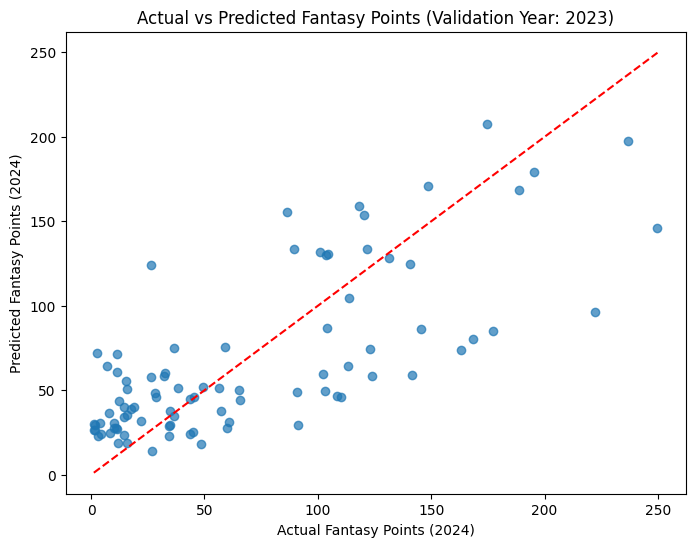

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()

#### Feature importances
##### The top three most predictive features for tight ends are the same as for wide receivers, with targets and receptions being swapped. This makes intuitive sense; the same metrics are used to evaluate fantasy production for tight ends and wide receivers. Perhaps targets are more predictive here than for WRs because they also capture a tight end's usage. Often a tight end may have a large share of the snaps but not be utilized in the pass game.

In [ ]:
importance = model.feature_importances_
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(15))  # Top 15 features

              Feature  Importance
3             Yds_Rec    0.219625
1                 Tgt    0.201992
2                 Rec    0.095219
15  Yds_rec_last_year    0.051273
14      Rec_last_year    0.039200
5                  TD    0.036987
8           TM SNAP %    0.031465
18        Tgt_2_years    0.031428
4         Yds_per_rec    0.030411
13      Tgt_last_year    0.030345
7         Total_Snaps    0.028732
19      Snaps_2_years    0.027549
6        TD_last_year    0.025192
12    Snaps_last_year    0.023837
0                 Age    0.023582


#### 2025 Predictions TEs

In [27]:
future_preds = model.predict(X_test)
TEs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_39868/1835647429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEs_test['2025_Fantasy_Projection'] = future_preds


## Positional Rankings (Model Preictions 2025)
##### The following bar plots show the predictions for the top fifteen fantasy point scorers at each position. I was pleasantly surprised by the names towards the top of each list since – generally speaking – the players are those which the fantasy football community projects to finish as top players this coming season.

##### There are a few players that stood out as being unlikely to finish in the spot that the model predicted them to finish. 
##### First, Jared Goff is unlikely to finish second in fantasy points. He just does not have the rushing upside as the other names around him. It would take an MVP type season through the air for him to come close to Daniels, Jackson, Allen, and even Nix.
##### Secondly, Rachaad White is unlikely to finish in the top five for running backs. I imagine the model is taking his volume from the past few seasons into account, but this season he is projected to be the backup to Bucky Irving, the player just behind White in the prediction.
##### The Wide Receiver and Tight End predictions look accurate to my eye, though Jordan Addison's position is a tad bit rich (he is suspended three games and is behind another receiver on the depth chart)

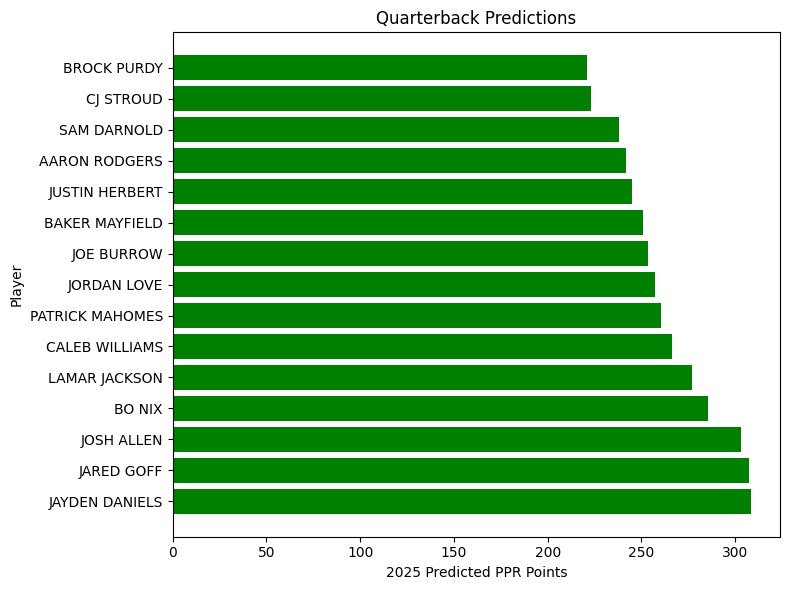

In [28]:
QBs_rankings = QBs_test.sort_values('2025_Fantasy_Projection', ascending=False).head(15)
plt.figure(figsize=(8,6))
plt.barh(QBs_rankings['Player'], QBs_rankings['2025_Fantasy_Projection'], color='green')
plt.title('Quarterback Predictions', loc='center')
plt.xlabel('2025 Predicted PPR Points')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

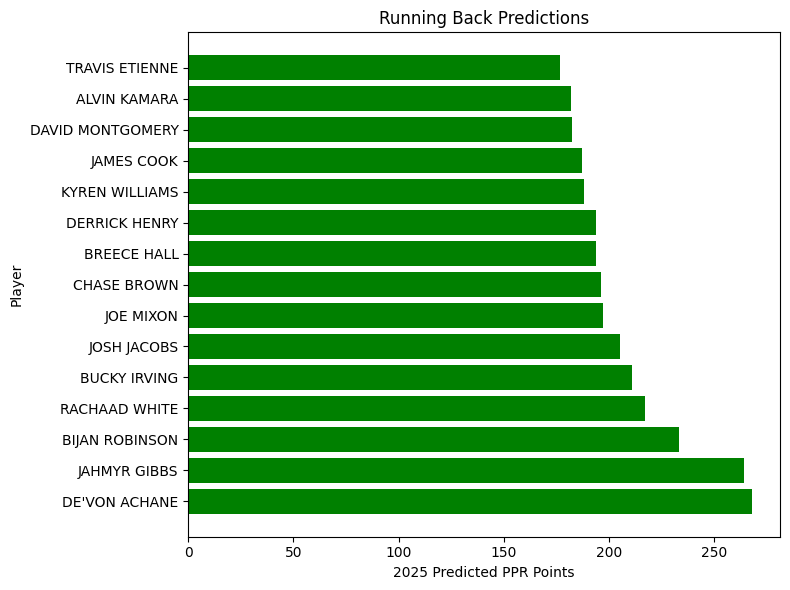

In [29]:
RBs_rankings = RBs_test.sort_values('2025_Fantasy_Projection', ascending=False).head(15)
plt.figure(figsize=(8,6))
plt.barh(RBs_rankings['Player'], RBs_rankings['2025_Fantasy_Projection'], color='green')
plt.title('Running Back Predictions', loc='center')
plt.xlabel('2025 Predicted PPR Points')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

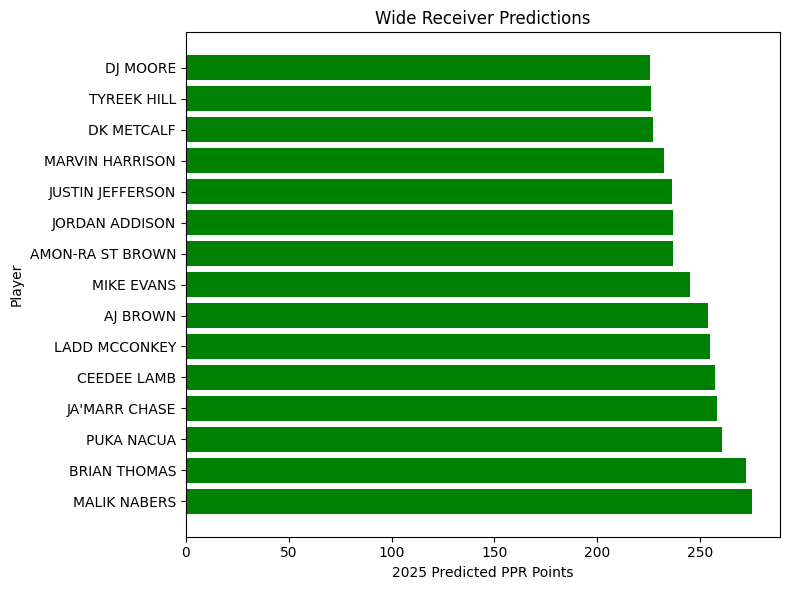

In [67]:
WRs_rankings = WRs_test.sort_values('2025_Fantasy_Projection', ascending=False).head(15)
plt.figure(figsize=(8,6))
plt.barh(WRs_rankings['Player'], WRs_rankings['2025_Fantasy_Projection'], color='green')
plt.title('Wide Receiver Predictions', loc='center')
plt.xlabel('2025 Predicted PPR Points')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

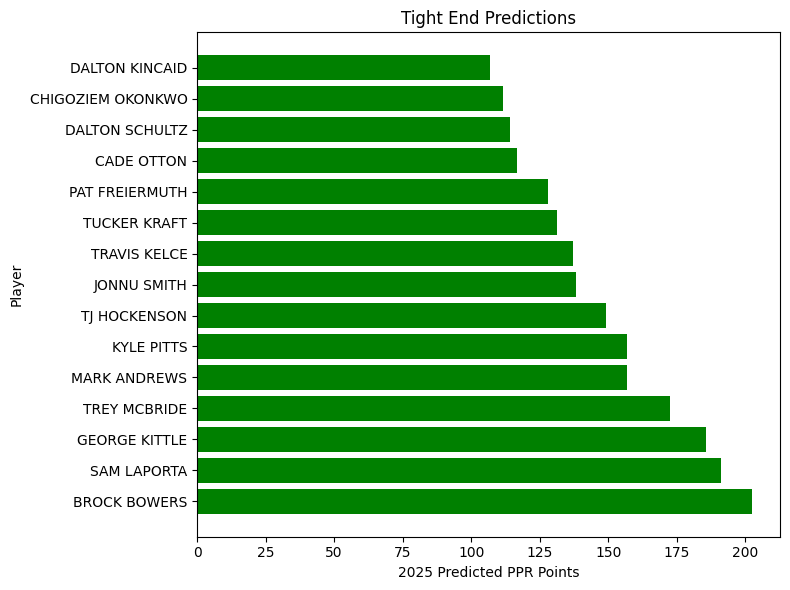

In [68]:
TEs_rankings = TEs_test.sort_values('2025_Fantasy_Projection', ascending=False).head(15)
plt.figure(figsize=(8,6))
plt.barh(TEs_rankings['Player'], TEs_rankings['2025_Fantasy_Projection'], color='green')
plt.title('Tight End Predictions', loc='center')
plt.xlabel('2025 Predicted PPR Points')
plt.ylabel('Player')
plt.tight_layout()
plt.show()